In [1]:
import cmocean.cm as cm
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import scipy.interpolate as interp
from scipy.stats import binned_statistic_2d

%matplotlib inline

In [4]:
mymesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdept_1d)

In [5]:
years = 5
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
int_mo = [1,2,3,4,5,6,7,8,9,10,11,12]
sections = [4,5,6] #haro, sanjuan, and rosario go into the JDF

In [6]:
# in you CS versions the comversion from m3/s to m/s happened via the binning+density step since you were dividing 
# by bin depth AND width, now you are only dividing by bin height SO must add an extra step where you divide by width
# for this stage i think fine to figure out the number of grid cells at each depth across all three CSs, 
# then assume that all of them have a width of 500 m

#in the format [jgridW, jgridE, figrid]
rosario = [286, 307, 266]
sanjuan = [264, 266, 280]
haro = [218, 242, 304]

# indmax = 33
plotdepths = np.linspace(0,mymesh.gdept_1d[0,:][33],100)
#want to make a length 100 array with the total width for each depth

# find the number of cells (summed acrss the 3 CS) at each depth
figrid = [haro[2],sanjuan[2],rosario[2]]
lonW = [haro[0],sanjuan[0],rosario[0]]
lonE = [haro[1],sanjuan[1],rosario[1]]
igrid = [f-1 for f in figrid]
cells = np.zeros(33)

for i in range(len(igrid)):
    for d in range(33):
        fmask = mymesh.fmask[0, :, igrid[i],lonW[i]-2:lonE[i]+1]
        cells[d] += np.count_nonzero(fmask[d])

# find which depths you are plotting with fit into which SSC depth range
num = np.histogram(plotdepths,bins=mymesh.gdept_1d[0,:34])[0]
num[0] = 1

# based on this calc the total width at each plotting depth
width = np.array([])

for i in range(len(cells)):
    width = np.append(width,np.repeat(cells[i],num[i]))
width *= 500
width[0] = width[1]

#make a mesh of this indo so that you can easily divide 
_, W = np.meshgrid(np.arange(1,(years*12)+1,1), width)

In [7]:
def get_data(mydata, section, starttime, endtime):
#     lons = mydata.final_lon[(mydata.final_section==section) & (mydata.init_t==time)]
    depths = depthf(mydata.final_z[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]-1.)[0]
    transports = mydata.final_transp[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    tracer1 = mydata.final_temp[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    tracer2 = mydata.final_salt[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    return depths, transports, tracer1, tracer2

In [8]:
def get_all_data_SoG(folder,forback):
    starttime = 1
    endtime = 720

    depths = np.array([])
    transports = np.array([])
    tracer1 = np.array([])
    tracer2 = np.array([])
    month = np.array([])
    k = 0

    #2016 and 2017
    year = [16,17]

    for num in year:
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_'+str(folder)+'/'+str(forback)+'ward_01jan'+str(num)+'/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        for i in range(12):
            for section in sections:
                tempD, tempT, tempt1, tempt2 = get_data(mydata, section, starttime+(i*720), endtime+(i*720))

                depths = np.append(depths, tempD)
                transports = np.append(transports, tempT/720)
                tracer1 = np.append(tracer1, tempt1)
                tracer2 = np.append(tracer2, tempt2)
                month = np.append(month, np.full(len(tempD),i+k+1))
        k=12

    #2019 and 2018 (both done month by month)
    year = [18,19]
    for num in year:
        k += 12
        for i in range(len(str_mo)):
            file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_'+str(folder)+'/'+str(forback)+'ward_01'+str_mo[i]+str(num)+'/ariane_positions_quantitative.nc'
            mydata = xr.open_dataset(file)
            time = mydata.init_t[-1]

            for section in sections:
                depths = np.append(depths, depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0])
                tracer1 = np.append(tracer1, mydata.final_temp[(mydata.final_section==section)])
                tracer2 = np.append(tracer2, mydata.final_salt[(mydata.final_section==section)])
                transports = np.append(transports, mydata.final_transp[(mydata.final_section==section)]/time)
                month = np.append(month, np.full(len(mydata.final_salt[(mydata.final_section==section)]),i+k+1))

    #2020
    k=48
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_'+str(folder)+'/'+str(forback)+'ward_01jan20/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    for i in range(12):
        for section in sections:
            tempD, tempT, tempt1, tempt2 = get_data(mydata, section, starttime+(i*720), endtime+(i*720))

            depths = np.append(depths, tempD)
            transports = np.append(transports, tempT/720)
            tracer1 = np.append(tracer1, tempt1)
            tracer2 = np.append(tracer2, tempt2)
            month = np.append(month, np.full(len(tempD),i+k+1))
    
    return depths, transports, tracer1, tracer2, month

Text(0, 0.5, 'Depth (m)')

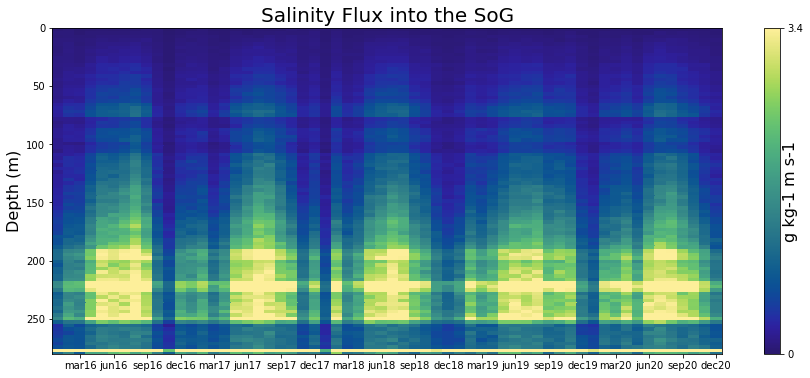

In [9]:
folder = '1hr'
forback = 'for'
depths, transports, tracer1, tracer2, month = get_all_data_SoG(folder,forback)
month_edge = np.arange(0.5,61.5,1)

vmax = (3.4/sum(transports))

H1, xedges1, yedges1 = np.histogram2d(month, depths, bins=[month_edge,100] ,weights= transports, density= True)# vmax=vmax)

H = binned_statistic_2d(month, depths, tracer2, statistic=np.mean, bins=[month_edge,100])
_, xedges, yedges = np.histogram2d(month, depths, bins = [month_edge,100])
   
H_final= (H1.T/W) * H.statistic.T
np.nan_to_num(H_final, nan=0, copy=False)

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
    
X, Y = np.meshgrid(xedges, yedges)
cmap = cm.haline
im = ax.pcolormesh(X, Y, H_final, vmax = vmax, vmin = 0, cmap=cmap)
cb1 = fig.colorbar(im, ax=ax)
cb1.set_ticks([0, vmax])
cb1.set_ticklabels([0, np.round((vmax * sum(transports)),1)])
cb1.set_label('g kg-1 m s-1', labelpad=-20,fontsize = 16)
    
ax.invert_yaxis()
ax.set_ylim((280, 0))
ax.set_xlim((0.5,60.5))
ax.set_title('Salinity Flux into the SoG', fontsize = 20)
ax.set_xticks(np.arange(3,61,3))
ax.set_xticklabels(['mar16','jun16','sep16','dec16','mar17','jun17','sep17','dec17','mar18','jun18','sep18','dec18','mar19','jun19','sep19','dec19','mar20','jun20','sep20','dec20'])
ax.set_ylabel('Depth (m)',fontsize = 16)

In [17]:
starttime = 1
endtime = 720

depths = np.array([])
transports = np.array([])
tracer1 = np.array([])
tracer2 = np.array([])
month = np.array([])
k = 0

#2016 and 2017
year = [16,17]

for num in year:
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1yr/forward_01jan'+str(num)+'/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    for i in range(12):
        for section in sections:
            tempD, tempT, tempt1, tempt2 = get_data(mydata, section, starttime+(i*720), endtime+(i*720))

            depths = np.append(depths, tempD)
            transports = np.append(transports, tempT/720)
#             tracer1 = np.append(tracer1, tempt1)
            tracer2 = np.append(tracer2, tempt2)
            month = np.append(month, np.full(len(tempD),i+k+1))
    k=12
    
#2019 and 2018 (both done month by month)
year = [18,19]
for num in year:
    k += 12
    for i in range(len(str_mo)):
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_tracers/forward_01'+str_mo[i]+str(num)+'/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        time = mydata.init_t[-1]

        for section in sections:
            depths = np.append(depths, depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0])
            tracer2 = np.append(tracer2, mydata.final_salt[(mydata.final_section==section)])
            transports = np.append(transports, mydata.final_transp[(mydata.final_section==section)]/time)
            month = np.append(month, np.full(len(mydata.final_salt[(mydata.final_section==section)]),i+k+1))

#2020
k=48
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1yr/forward_01jan20/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
for i in range(12):
    for section in sections:
        tempD, tempT, tempt1, tempt2 = get_data(mydata, section, starttime+(i*720), endtime+(i*720))

        depths = np.append(depths, tempD)
        transports = np.append(transports, tempT/720)
#            tracer1 = np.append(tracer1, tempt1)
        tracer2 = np.append(tracer2, tempt2)
        month = np.append(month, np.full(len(tempD),i+k+1))

Text(0, 0.5, 'Depth (m)')

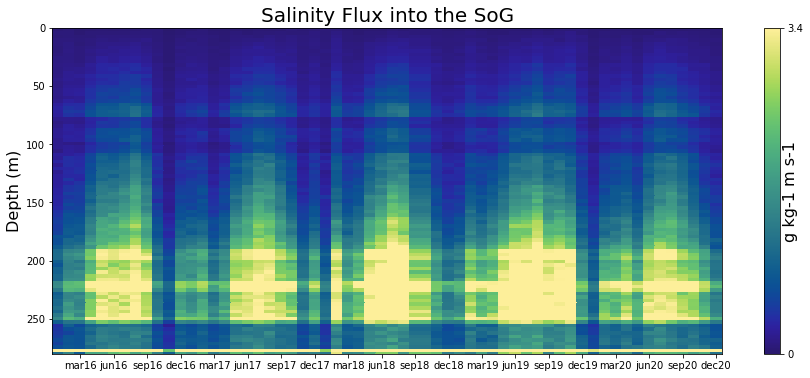

In [18]:
month_edge = np.arange(0.5,61.5,1)

vmax = (3.4/sum(transports))

H1, xedges1, yedges1 = np.histogram2d(month, depths, bins=[month_edge,100] ,weights= transports, density= True)# vmax=vmax)

H = binned_statistic_2d(month, depths, tracer2, statistic=np.mean, bins=[month_edge,100])
_, xedges, yedges = np.histogram2d(month, depths, bins = [month_edge,100])
   
H_final= (H1.T/W) * H.statistic.T
np.nan_to_num(H_final, nan=0, copy=False)

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
    
X, Y = np.meshgrid(xedges, yedges)
cmap = cm.haline
im = ax.pcolormesh(X, Y, H_final, vmax = vmax, vmin = 0, cmap=cmap)
cb1 = fig.colorbar(im, ax=ax)
cb1.set_ticks([0, vmax])
cb1.set_ticklabels([0, np.round((vmax * sum(transports)),1)])
cb1.set_label('g kg-1 m s-1', labelpad=-20,fontsize = 16)
    
ax.invert_yaxis()
ax.set_ylim((280, 0))
ax.set_xlim((0.5,60.5))
ax.set_title('Salinity Flux into the SoG', fontsize = 20)
ax.set_xticks(np.arange(3,61,3))
ax.set_xticklabels(['mar16','jun16','sep16','dec16','mar17','jun17','sep17','dec17','mar18','jun18','sep18','dec18','mar19','jun19','sep19','dec19','mar20','jun20','sep20','dec20'])
ax.set_ylabel('Depth (m)',fontsize = 16)

Text(0, 0.5, 'Depth (m)')

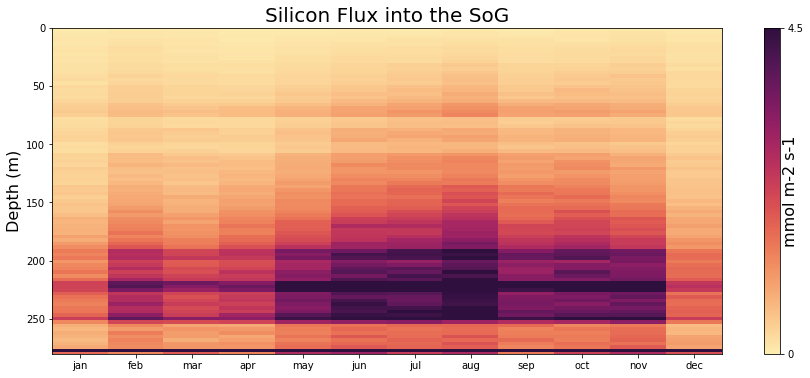

In [5]:
#SILICON FLUX
depths = np.array([])
salts = np.array([])
transports = np.array([])
month = np.array([])
time = 0

for i in range(len(str_mo)):
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_tracers/forward_01'+str_mo[i]+'19/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    time = mydata.init_t[-1]
    
    for section in sections:
        depths = np.append(depths, depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0])
        salts = np.append(salts, mydata.final_salt[(mydata.final_section==section)])
        transports = np.append(transports, mydata.final_transp[(mydata.final_section==section)]/time)
        month = np.append(month, np.full(len(mydata.final_salt[(mydata.final_section==section)]),int_mo[i]))

month_edge = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5]

vmax = (4.5/sum(transports))

H1, xedges1, yedges1 = np.histogram2d(month, depths, bins=[month_edge,100], weights= transports, density= True)

H = binned_statistic_2d(month, depths, salts, statistic=np.mean, bins=[month_edge,100])
_, xedges, yedges = np.histogram2d(month, depths, bins = [month_edge,100])
   
H_final= (H1.T/W) * H.statistic.T
np.nan_to_num(H_final, nan=0, copy=False)

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
    
X, Y = np.meshgrid(xedges1, yedges1)
cmap = cm.matter
im = ax.pcolormesh(X, Y, H_final, vmax=vmax, vmin=0, cmap=cmap)
cb1 = fig.colorbar(im, ax=ax)
cb1.set_ticks([0, vmax])
cb1.set_ticklabels([0, np.round((vmax * sum(transports)),1)])
cb1.set_label('mmol m-2 s-1', labelpad=-20, fontsize = 16)

ax.invert_yaxis()
ax.set_ylim((280, 0))
ax.set_title('Silicon Flux into the SoG', fontsize = 20)
ax.set_xticks(int_mo)
ax.set_xticklabels(str_mo)
ax.set_ylabel('Depth (m)', fontsize = 16)

Text(0, 0.5, 'Depth (m)')

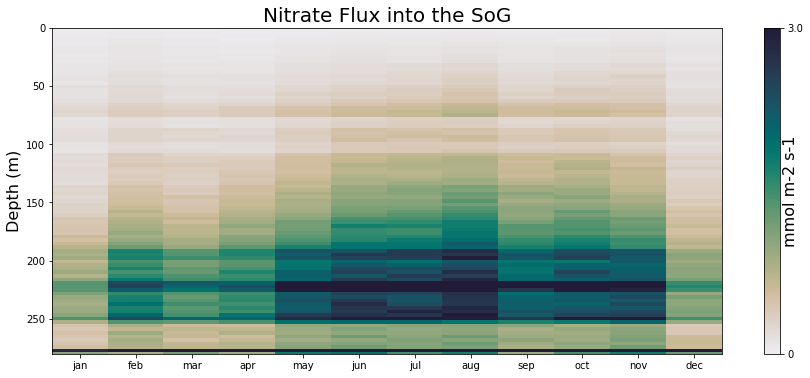

In [6]:
#NITRATE FLUX

str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
int_mo = [1,2,3,4,5,6,7,8,9,10,11,12]
sections = [4,5,6] #haro, sanjuan, and rosario go into the JDF

depths = np.array([])
tracer = np.array([])
transports = np.array([])
month = np.array([])

for i in range(len(str_mo)):
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_tracers/forward_01'+str_mo[i]+'19/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    time = mydata.init_t[-1]
    
    for section in sections:
        depths = np.append(depths, depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0])
        tracer = np.append(tracer, mydata.final_temp[(mydata.final_section==section)])
        transports = np.append(transports, mydata.final_transp[(mydata.final_section==section)]/time)
        month = np.append(month, np.full(len(mydata.final_salt[(mydata.final_section==section)]),int_mo[i]))
        
month_edge = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5]

vmax = (3.0/sum(transports))

H1, xedges1, yedges1 = np.histogram2d(month, depths, bins=[month_edge,100] ,weights= transports, density= True)# vmax=vmax)

H = binned_statistic_2d(month, depths, tracer, statistic=np.mean, bins=[month_edge,100])
_, xedges, yedges = np.histogram2d(month, depths, bins = [month_edge,100])
   
H_final= (H1.T/W) * H.statistic.T
np.nan_to_num(H_final, nan=0, copy=False)

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
    
X, Y = np.meshgrid(xedges, yedges)
cmap = cm.rain
im = ax.pcolormesh(X, Y, H_final, vmax = vmax, vmin = 0, cmap=cmap)
cb1 = fig.colorbar(im, ax=ax)
cb1.set_ticks([0, vmax])
cb1.set_ticklabels([0, np.round((vmax * sum(transports)),1)])
cb1.set_label('mmol m-2 s-1', labelpad=-20,fontsize = 16)
    
ax.invert_yaxis()
ax.set_ylim((280, 0))
ax.set_title('Nitrate Flux into the SoG', fontsize = 20)
ax.set_xticks(int_mo)
ax.set_xticklabels(str_mo)
ax.set_ylabel('Depth (m)',fontsize = 16)

Text(0, 0.5, 'Depth (m)')

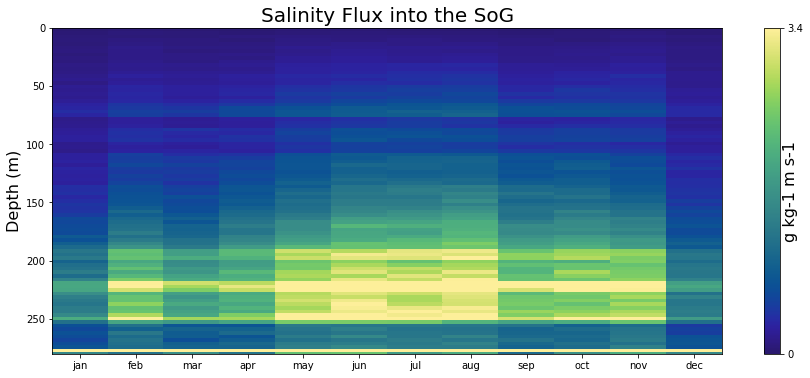

In [7]:
#SALINITY FLUX

str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
int_mo = [1,2,3,4,5,6,7,8,9,10,11,12]
sections = [4,5,6] #haro, sanjuan, and rosario go into the JDF

depths = np.array([])
tracer = np.array([])
transports = np.array([])
month = np.array([])

for i in range(len(str_mo)):
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01'+str_mo[i]+'19/ariane_positions_quantitative.nc'
    mydata2 = xr.open_dataset(file)
    time2 = mydata.init_t[-1]
    
    for section in sections:
        depths = np.append(depths, depthf(mydata2.final_z[(mydata2.final_section==section)]-1.)[0])
        tracer = np.append(tracer, mydata2.final_salt[(mydata2.final_section==section)])
        transports = np.append(transports, mydata2.final_transp[(mydata2.final_section==section)]/time)
        month = np.append(month, np.full(len(mydata2.final_salt[(mydata2.final_section==section)]),int_mo[i]))
        
month_edge = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5]

vmax = (3.4/sum(transports))

H1, xedges1, yedges1 = np.histogram2d(month, depths, bins=[month_edge,100] ,weights= transports, density= True)# vmax=vmax)

H = binned_statistic_2d(month, depths, tracer, statistic=np.mean, bins=[month_edge,100])
_, xedges, yedges = np.histogram2d(month, depths, bins = [month_edge,100])
   
H_final= (H1.T/W) * H.statistic.T
np.nan_to_num(H_final, nan=0, copy=False)

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
    
X, Y = np.meshgrid(xedges, yedges)
cmap = cm.haline
im = ax.pcolormesh(X, Y, H_final, vmax = vmax, vmin = 0, cmap=cmap)
cb1 = fig.colorbar(im, ax=ax)
cb1.set_ticks([0, vmax])
cb1.set_ticklabels([0, np.round((vmax * sum(transports)),1)])
cb1.set_label('g kg-1 m s-1', labelpad=-20,fontsize = 16)
    
ax.invert_yaxis()
ax.set_ylim((280, 0))
ax.set_title('Salinity Flux into the SoG', fontsize = 20)
ax.set_xticks(int_mo)
ax.set_xticklabels(str_mo)
ax.set_ylabel('Depth (m)',fontsize = 16)

Text(0, 0.5, 'Depth (m)')

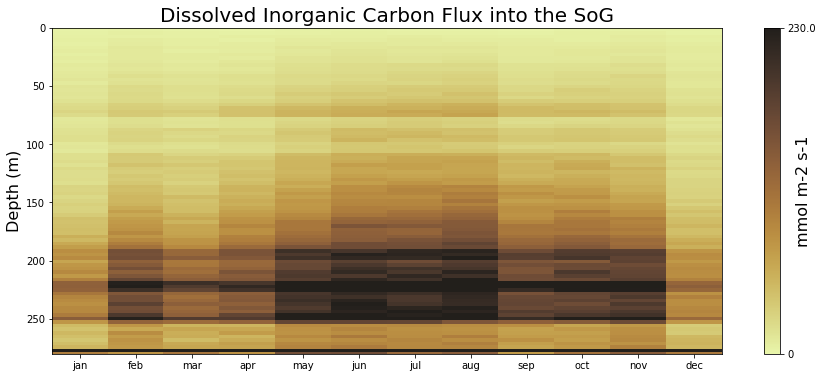

In [8]:
#CARBON FLUX

str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
int_mo = [1,2,3,4,5,6,7,8,9,10,11,12]
sections = [4,5,6] #haro, sanjuan, and rosario go into the JDF

depths = np.array([])
tracer = np.array([])
transports = np.array([])
month = np.array([])

for i in range(len(str_mo)):
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01'+str_mo[i]+'19/ariane_positions_quantitative.nc'
    mydata2 = xr.open_dataset(file)
    time = mydata2.init_t[-1]
    
    for section in sections:
        depths = np.append(depths, depthf(mydata2.final_z[(mydata2.final_section==section)]-1.)[0])
        tracer = np.append(tracer, mydata2.final_temp[(mydata2.final_section==section)])
        transports = np.append(transports, mydata2.final_transp[(mydata2.final_section==section)]/time)
        month = np.append(month, np.full(len(mydata2.final_salt[(mydata2.final_section==section)]),int_mo[i]))
        
month_edge = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5]

vmax = (230/sum(transports))

H1, xedges1, yedges1 = np.histogram2d(month, depths, bins=[month_edge,100] ,weights= transports, density= True)# vmax=vmax)

H = binned_statistic_2d(month, depths, tracer, statistic=np.mean, bins=[month_edge,100])
_, xedges, yedges = np.histogram2d(month, depths, bins = [month_edge,100])
   
H_final= (H1.T/W) * H.statistic.T
np.nan_to_num(H_final, nan=0, copy=False)

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
    
X, Y = np.meshgrid(xedges, yedges)
cmap = cm.turbid
im = ax.pcolormesh(X, Y, H_final, vmax = vmax, vmin = 0, cmap=cmap)
cb1 = fig.colorbar(im, ax=ax)
cb1.set_ticks([0, vmax])
cb1.set_ticklabels([0, np.round((vmax * sum(transports)),1)])
cb1.set_label('mmol m-2 s-1', labelpad=-20, fontsize=16)
    
ax.invert_yaxis()
ax.set_ylim((280, 0))
ax.set_title('Dissolved Inorganic Carbon Flux into the SoG', fontsize = 20)
ax.set_xticks(int_mo)
ax.set_xticklabels(str_mo)
ax.set_ylabel('Depth (m)', fontsize=16)

In [9]:
nitr_sum_for = np.array([])
sili_sum_for = np.array([])
saln_sum_for = np.array([])
carb_sum_for = np.array([])

for i in range(len(str_mo)):
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_tracers/forward_01'+str_mo[i]+'19/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01'+str_mo[i]+'19/ariane_positions_quantitative.nc'
    mydata2 = xr.open_dataset(file)
    
    tracerN = np.array([])
    tracerSi = np.array([])
    tracerSa = np.array([])
    tracerC = np.array([])
    transports = np.array([])
#     transports2 = np.array([])
    
    for section in sections:
        time = mydata.init_t[-1]
        transports = np.append(transports, mydata.final_transp[(mydata.final_section==section)]/time)
#         time = mydata2.init_t[-1]
#         transports2 = np.append(transports2, mydata2.final_transp[(mydata2.final_section==section)]/time)
        
        tracerN = np.append(tracerN, mydata.final_temp[(mydata.final_section==section)])
        tracerSi = np.append(tracerSi, mydata.final_salt[(mydata.final_section==section)])
        tracerC = np.append(tracerC, mydata2.final_temp[(mydata2.final_section==section)])
        tracerSa = np.append(tracerSa, mydata2.final_salt[(mydata2.final_section==section)])
    
    nitr_sum_for = np.append(nitr_sum_for,sum(tracerN*transports)/1000*(62.0049/1000))
    sili_sum_for = np.append(sili_sum_for,sum(tracerSi*transports)/1000*(60.08/1000))
    carb_sum_for = np.append(carb_sum_for,sum(tracerC*transports)/1000*(44.01/1000)) #assuming mostly carbon dioxide?
    saln_sum_for = np.append(saln_sum_for,sum(tracerSa*transports))  

In [10]:
nitr_sum_back = np.array([])
sili_sum_back = np.array([])
saln_sum_back = np.array([])
carb_sum_back = np.array([])

str_back = ['31jan','03mar','31mar','01may','31may','01jul','31jul','31aug','01oct','31oct','01dec','31dec']#need a seperate string for this as the backward run names are slightly less consistent

for i in range(len(str_back)):
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_tracers/backward_'+str_back[i]+'19/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/backward_'+str_back[i]+'19/ariane_positions_quantitative.nc'
    mydata2 = xr.open_dataset(file)
    
    tracerN = np.array([])
    tracerSi = np.array([])
    tracerSa = np.array([])
    tracerC = np.array([])
    transports = np.array([])
#     transports2 = np.array([])
    
    for section in sections:
        transports = np.append(transports, mydata.final_transp[(mydata.final_section==section)]/time)
#         time = mydata2.init_t[-1]
#         transports2 = np.append(transports2, mydata2.final_transp[(mydata2.final_section==section)]/time)
        
        tracerN = np.append(tracerN, mydata.final_temp[(mydata.final_section==section)])
        tracerSi = np.append(tracerSi, mydata.final_salt[(mydata.final_section==section)])
        tracerC = np.append(tracerC, mydata2.final_temp[(mydata2.final_section==section)])
        tracerSa = np.append(tracerSa, mydata2.final_salt[(mydata2.final_section==section)])
    
    nitr_sum_back = np.append(nitr_sum_back,sum(tracerN*transports)/1000*(62.0049/1000))
    sili_sum_back = np.append(sili_sum_back,sum(tracerSi*transports)/1000*(60.08/1000))
    carb_sum_back = np.append(carb_sum_back,sum(tracerC*transports)/1000*(44.01/1000)) #assuming mostly carbon dioxide?
    saln_sum_back = np.append(saln_sum_back,sum(tracerSa*transports)) 

Text(0, 0.5, 'Tracer Flow into the SoG [kg/s]')

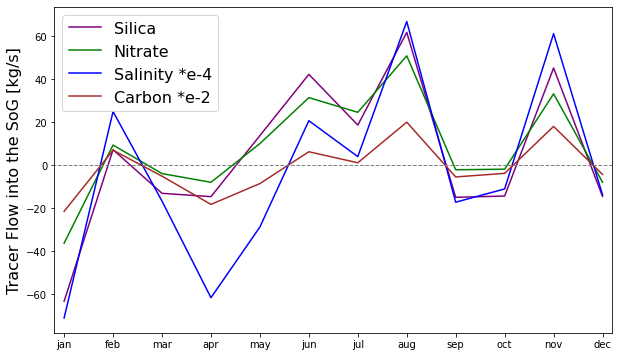

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
# ax.plot(nitr_sum_for, c='b',alpha=0.4)
# ax.plot(nitr_sum_back*-1,c='b',alpha=0.4)

# ax.plot(sili_sum_for, c='r',alpha=0.4)
# ax.plot(sili_sum_back*-1,c='r',alpha=0.4)

ax.plot(sili_sum_for-sili_sum_back,label='Silica', c='purple')
ax.plot(nitr_sum_for-nitr_sum_back,label='Nitrate', c='green')
ax.plot((saln_sum_for-saln_sum_back)/10000,label='Salinity *e-4', c='b')
ax.plot((carb_sum_for-carb_sum_back)/100,label='Carbon *e-2', c='brown')

ax.plot(np.arange(-1,len(str_mo)+1), np.full(len(str_mo)+2,0), c='grey',ls='--',lw=1)

ax.legend(fontsize = 16)
# ax.set_ylim([-200,200])
# ax.set_yscale('log')
ax.set_xticks(np.arange(0,len(str_mo)))
ax.set_xticklabels(str_mo)
ax.set_xlim(-0.2,len(str_mo)-0.8)
ax.set_ylabel('Tracer Flow into the SoG [kg/s]', fontsize = 16)